In [1]:
import io

import numpy as np
import matplotlib.pyplot as plt

from ase.io import read, write

from molent.molent import binary_similarity, cosine_similarity
from molent.twomol import mixing_entropy, mixing_gain, average_kernel, bestmatch_kernel

# Read Data from QM9 Dataset

The dataset can be downloaded from https://doi.org/10.6084/m9.figshare.c.978904.v5

In [2]:
qm9_dir = '../../../QM9/dsgdb9nsd.xyz/' # adjust to your QM9 directory

In [3]:
from molent.tools import cleanup_qm9_xyz

all_atoms = []
all_smiles = []

for i in range(1,185):
    ind, gdb_smi, relax_smi = cleanup_qm9_xyz(qm9_dir+'dsgdb9nsd_%06i.xyz' % i)
    
    all_atoms.append(read(io.StringIO(ind), format='xyz'))
    all_smiles.append(relax_smi)

# Fragment Smiles &rarr; Molecule Similarity

In [4]:
from molent.molent import fragment_smiles

N_rad = 3 # the only parameter is the "size" of the local environments (no. of bonds from atom) 

frag_smiles = fragment_smiles(all_smiles, N_rad = N_rad, useHs = True)

In [5]:
Nmols = len(frag_smiles)

smi_gain_entropies = np.zeros((Nmols,Nmols))
smi_maxmix_entropies = np.ones((Nmols,Nmols))

smi_avg_kernels = np.ones((Nmols,Nmols))
smi_bm_kernels = np.ones((Nmols,Nmols))
smi_avg_sq_kernels = np.ones((Nmols,Nmols))
smi_bm_sq_kernels = np.ones((Nmols,Nmols))


for i in range(Nmols):
    smiles1 = frag_smiles[i]    
    n1 = len(smiles1)
        
    for j in range(0,i):
        smiles2 = frag_smiles[j]
        n2 = len(smiles2)
        
        sim12 = binary_similarity(smiles1+smiles2)
                
        smi_gain_entropies[i,j] = mixing_gain(sim12, [n1, n2])
        smi_gain_entropies[j,i] = smi_gain_entropies[i,j]
        
        smi_maxmix_entropies[i,j] = mixing_entropy(n1, n2)
        smi_maxmix_entropies[j,i] = smi_maxmix_entropies[i,j]

        smi_avg_kernels[i,j] = average_kernel(sim12, [n1, n2], p=1)
        smi_avg_kernels[j,i] = smi_avg_kernels[i,j]

        smi_avg_sq_kernels[i,j] = average_kernel(sim12, [n1, n2], p=2)
        smi_avg_sq_kernels[j,i] = smi_avg_sq_kernels[i,j]
        
        smi_bm_kernels[i,j] = bestmatch_kernel(sim12, [n1, n2], p=1)
        smi_bm_kernels[j,i] = smi_bm_kernels[i,j]
        
        smi_bm_sq_kernels[i,j] = bestmatch_kernel(sim12, [n1, n2], p=2)
        smi_bm_sq_kernels[j,i] = smi_bm_sq_kernels[i,j]
        

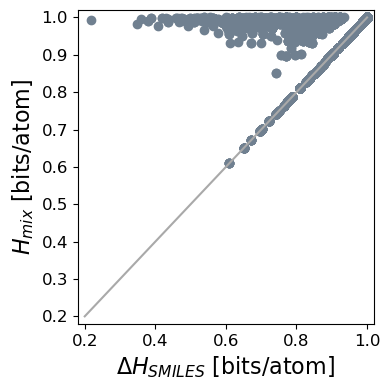

In [6]:
triu_ind = np.triu_indices(smi_gain_entropies.shape[0])

fig, ax1 = plt.subplots(1, 1, figsize=(4,4), sharey=True)

ax1.scatter(smi_gain_entropies[triu_ind], smi_maxmix_entropies[triu_ind], color='slategrey')
ax1.plot([0.2, 1.], [0.2, 1.], color='darkgrey')

ax1.set_xlabel(r'$\Delta H_{SMILES}$ [bits/atom]', fontsize=16)
ax1.set_ylabel(r'$H_{mix}$ [bits/atom]', fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_xlim((0.18,1.02))
ax1.set_ylim((0.18,1.02))

plt.tight_layout()
plt.show()
#plt.savefig('/Users/acroy/TeX/Papers/MOLENT/twomol_ent_smiles_mixing.pdf')

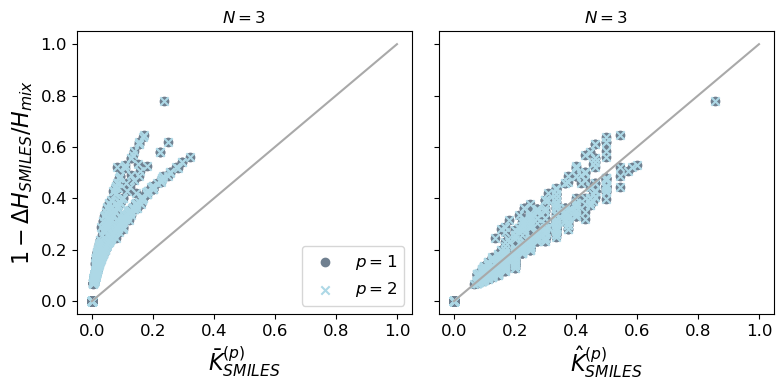

In [7]:
triu_ind = np.triu_indices(smi_gain_entropies.shape[0], k=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4), sharey=True)
ax1.scatter(smi_avg_kernels[triu_ind], 1 - smi_gain_entropies[triu_ind]/smi_maxmix_entropies[triu_ind], 
            color='slategrey', label=r'$p=1$')
ax1.scatter(smi_avg_sq_kernels[triu_ind], 1 - smi_gain_entropies[triu_ind]/smi_maxmix_entropies[triu_ind], 
            color='lightblue', marker='x', label=r'$p=2$')
ax1.plot([0., 1.], [0., 1.], color='darkgrey')

ax1.legend(loc='lower right', fontsize=12)
ax1.set_title(r'$N=%i$' % N_rad)
ax1.set_xlabel(r'$\bar{K}^{(p)}_{SMILES}$', fontsize=16)
ax1.set_ylabel(r'$1 - \Delta H_{SMILES} / H_{mix}$', fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=12)

ax2.scatter(smi_bm_kernels[triu_ind], 1 - smi_gain_entropies[triu_ind]/smi_maxmix_entropies[triu_ind], 
            color='slategrey')
ax2.scatter(smi_bm_sq_kernels[triu_ind], 1 - smi_gain_entropies[triu_ind]/smi_maxmix_entropies[triu_ind], 
            color='lightblue', marker='x')

ax2.plot([0., 1.], [0., 1.], color='darkgrey')

ax2.set_title(r'$N=%i$' % N_rad)
ax2.set_xlabel(r'$\hat{K}^{(p)}_{SMILES}$', fontsize=16)
ax2.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()
#plt.savefig('twomol_ent_smiles_gain.pdf')

# SOAP &rarr; Molecule Similarity

In [8]:
from dscribe.descriptors import SOAP

# SOAP parameters
species = ["C", "H", "O", "N", "F"]
r_cut = 6.
n_max = 10
l_max = 6

# setting up the SOAP descriptor
soap = SOAP(
    species=species,
    periodic=False,
    r_cut=r_cut,
    n_max=n_max,
    l_max=l_max,
)

soap_mol = soap.create(all_atoms)

In [9]:
zeta = 16

gain_entropies = np.zeros((len(all_atoms),len(all_atoms)))
maxmix_entropies = np.ones((len(all_atoms),len(all_atoms)))

avg_kernels = np.ones((len(all_atoms),len(all_atoms)))
bestmatch_kernels = np.ones((len(all_atoms),len(all_atoms)))

avg_sq_kernels = np.ones((len(all_atoms),len(all_atoms)))
bestmatch_sq_kernels = np.ones((len(all_atoms),len(all_atoms)))


for i in range(len(all_atoms)):
    at_nums_i = all_atoms[i].get_atomic_numbers()
    n1 = len(at_nums_i)    
    
    for j in range(0, i):

        at_nums_j = all_atoms[j].get_atomic_numbers()
        n2 = len(at_nums_j)
        
        soap_mol_ij = np.concatenate([soap_mol[i], soap_mol[j]])
        at_nums_ij = np.concatenate([at_nums_i, at_nums_j])
        
        sim12 = cosine_similarity(soap_mol_ij, at_nums=at_nums_ij)**zeta

        gain_entropies[i,j] = mixing_gain(sim12, [n1, n2])
        gain_entropies[j,i] = gain_entropies[i,j]
        
        maxmix_entropies[i,j] =  mixing_entropy(n1, n2)
        maxmix_entropies[j,i] = maxmix_entropies[i,j]

        avg_kernels[i,j] = average_kernel(sim12, [n1, n2], p=1)
        avg_kernels[j,i] = avg_kernels[i,j]

        avg_sq_kernels[i,j] = average_kernel(sim12, [n1, n2], p=2)
        avg_sq_kernels[j,i] = avg_sq_kernels[i,j]

        bestmatch_kernels[i,j] = bestmatch_kernel(sim12, [n1, n2], p=1)
        bestmatch_kernels[j,i] = bestmatch_kernels[i,j]

        bestmatch_sq_kernels[i,j] = bestmatch_kernel(sim12, [n1, n2], p=2)
        bestmatch_sq_kernels[j,i] = bestmatch_sq_kernels[i,j]

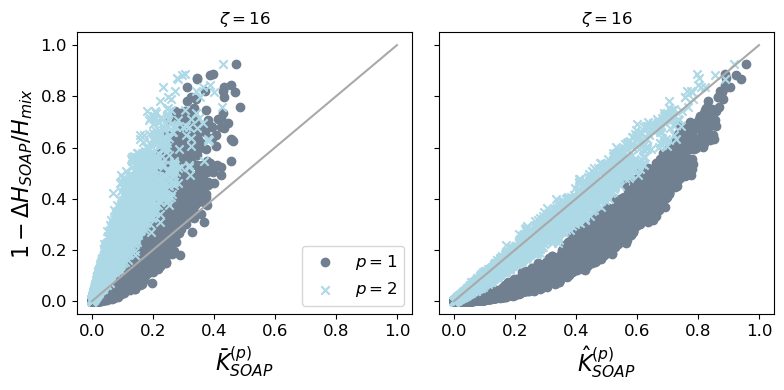

In [10]:
triu_ind = np.triu_indices(gain_entropies.shape[0], k=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4), sharey=True)
ax1.scatter(avg_kernels[triu_ind], 1 - gain_entropies[triu_ind]/maxmix_entropies[triu_ind], 
            color='slategrey', label=r'$p=1$')
ax1.scatter(avg_sq_kernels[triu_ind], 1 - gain_entropies[triu_ind]/maxmix_entropies[triu_ind], 
            color='lightblue', marker='x', label=r'$p=2$')

ax1.plot([0., 1.], [0., 1.], color='darkgrey')

ax1.legend(loc='lower right', fontsize=12)
ax1.set_title(r'$\zeta=%i$' % zeta)
#ax1.set_aspect('equal')
ax1.set_xlabel(r'$\bar{K}^{(p)}_{SOAP}$', fontsize=16)
ax1.set_ylabel(r'$1 - \Delta H_{SOAP} / H_{mix}$', fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=12)

ax2.scatter(bestmatch_kernels[triu_ind], 1 - gain_entropies[triu_ind]/maxmix_entropies[triu_ind], color='slategrey')
ax2.scatter(bestmatch_sq_kernels[triu_ind], 1 - gain_entropies[triu_ind]/maxmix_entropies[triu_ind], 
            color='lightblue', marker='x')

ax2.plot([0., 1.], [0., 1.], color='darkgrey')

ax2.set_title(r'$\zeta=%i$' % zeta)
ax2.set_xlabel(r'$\hat{K}^{(p)}_{SOAP}$', fontsize=16)
ax2.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()
#plt.savefig('twomol_ent_soap_gain.pdf')